### Case Study 1 : Part 2 ( Feature Engineering + Machine leaning modeling )

# Google QUEST Q&A Labeling
Improving automated understanding of complex question answer content.


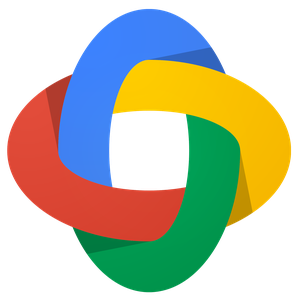

In [4]:
from io import BytesIO
import requests
from PIL import Image
response = requests.get("https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2F1.bp.blogspot.com%2F-qKqxEyuXEQo%2FVD71mHi8sDI%2FAAAAAAAAPhg%2FVwDyvAlXDnY%2Fs1600%2Frgicontransparent.png&f=1&nofb=1")
img = Image.open(BytesIO(response.content))
img.resize((300,300), Image.ANTIALIAS)

## Workflow

#### 1. Problem Statement and source
#### 2. Business Constrain and Dataset Loading
#### 3. Machine learning Formulation and Evalution mtric
#### 4. Loading Dataset
#### 5. Exploratory Data Analyses
#### 6. Insights and Findings
#### 7. Preprocessing and Feature engineering 
#### 8. Modeling and Hyperparameter tuning 
#### 9. Results and Conclusion


In [5]:
# Ignore all your warnings
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Loading Libraries
import datetime
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import pickle

import re
import pickle
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import os
from wordcloud import WordCloud
from matplotlib_venn import venn2
import re
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
eng_stopwords = stopwords.words('english')
import gc
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import tensorflow

#### After Exploratory Data Analyses . . . .

In [6]:
# Loading the Dataset
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

## 7. Preprocessing and Feature engineering

### 7.1. Preprocessing

#### 7.1.1  Preprocessing Functions

In [7]:
# Preprocessing Functions
# credit : https://www.kaggle.com/urvishp80/quest-encoding-ensemble

mispell_dict = {"aren't" : "are not","can't" : "cannot","couldn't" : "could not","couldnt" : "could not","didn't" : "did not","doesn't" : "does not",
                "doesnt" : "does not","don't" : "do not","hadn't" : "had not","hasn't" : "has not","haven't" : "have not","havent" : "have not",
                "he'd" : "he would","he'll" : "he will","he's" : "he is","i'd" : "I would","i'd" : "I had","i'll" : "I will","i'm" : "I am",
                "isn't" : "is not","it's" : "it is","it'll":"it will","i've" : "I have","let's" : "let us","mightn't" : "might not",
                "mustn't" : "must not","shan't" : "shall not","she'd" : "she would","she'll" : "she will","she's" : "she is","shouldn't" : "should not",
                "shouldnt" : "should not","that's" : "that is","thats" : "that is","there's" : "there is","theres" : "there is","they'd" : "they would",
                "they'll" : "they will","they're" : "they are","theyre":  "they are","they've" : "they have","we'd" : "we would","we're" : "we are",
                "weren't" : "were not","we've" : "we have","what'll" : "what will","what're" : "what are","what's" : "what is","what've" : "what have",
                "where's" : "where is","who'd" : "who would","who'll" : "who will","who're" : "who are","who's" : "who is","who've" : "who have",
                "won't" : "will not","wouldn't" : "would not","you'd" : "you would","you'll" : "you will","you're" : "you are","you've" : "you have",
                "'re": " are","wasn't": "was not","we'll":" will","didn't": "did not","tryin'":"trying"}


imp_keywords = ("R", "r", "C","c", "os", "OS")


# Counting the numeric feature and removing it
def count_digits_and_remove(text):
    """
    counting the number of occurance of digit
    
    return : text , (n_total_digit, n_2_digit, n_3_digit, n_4_digit, n_5_plus_digit)
    
    n_total_digit  : Total occurance of numeric feature
    n_2_digit      : Number of time 2 digit numeric feature occur
    n_2_digit      : Number of time 3 digit numeric feature occur
    n_2_digit      : Number of time 4 digit numeric feature occur
    n_5_plus_digit : Number of time more than 4 digit numeric feature occur
    
    """
    digits = re.findall(r'[0-9]+',text)

    n_total_digit = []
    n_2_digit = []
    n_3_digit = []
    n_4_digit = []
    n_5_plus_digit = []

    n_total_digit.append(len(digits))
    for digit in digits:
        if len(digit)==2:
            n_2_digit.append(digit)

        elif len(digit)==3:
            n_3_digit.append(digit)

        elif len(digit)==4:
            n_4_digit.append(digit)

        elif len(digit)>4:
            n_5_plus_digit.append(digit)
    
    # remove all the numbers
    text = re.sub(r'[0-9]+'," ",text)
            
    return text , (len(n_total_digit), len(n_2_digit), len(n_3_digit), len(n_4_digit), len(n_5_plus_digit))

#======================================================================================================================================
# Counting number of non_alpha_numeric character and removing all the special character words
def count_non_alpha_numeric_and_remove(text):  
    """ Counting number of non_alpha_numeric character(for programinng context) """
    
    # finding all the all the non_alpha_numeric char
    n_special_char = (re.findall(r"[^A-Za-z0-9 :]", text))
    
    # removing it.
    text = re.sub(r"[^A-Za-z0-9]", " ",text)
    
    return text ,len(n_special_char)

#======================================================================================================================================
# Counting the number of all capital word(maybe it would be corelated with labels) and coverting into lower string character
def count_all_cap_words_and_lower_it(text):
    
    """Finding the number of all capital word and lower it"""

    # Find all the capital words
    n_all_capital_words = (re.findall(pattern = r'([A-Z]([A-Z])+)',string=text))
    
    # converting into string into lower char string
    text = text.lower()
    
    return text , len(n_all_capital_words)

#======================================================================================================================================
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

def replace_typical_misspell(text):
    
    """De-Concatenation of words and correction of misspelled words"""
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

#======================================================================================================================================

# Return the number of links and text without html tags 
# Also return the counts of 'number of lines'  and remove it
def strip_html(text):
    """ 
    Return the number of links and clean text (without html tags) 
    Also return the counts of 'number of lines'  and remove it
    
    """
    # finding http links using regex and counting it and remove it
    n_links = (re.findall(r'http[s]?://\S+',text))
    text = re.sub(r'http[s]?://\S+'," ",text)
    
    # finding number of lines using regex and counting it and remove it
    n_lines = re.findall(r'\n',text)
    text = re.sub(r'\n', " ",text)
    
    return  text, len(n_links) , len(n_lines)

#======================================================================================================================================
# function to remove all the stopwords and words having lengths less than 3
def remove_stop_words_and_punc(text) :
    
    """ 
    Remove all the stopwords 
    Remove all the words whose length is less than 3 and not belong to important keywords(e.g. 'C','R','OS' etc)
    
    """
    # removing the words from the stop words list: 'no', 'nor', 'not'
    stops = set(stopwords.words("english"))
    stops.remove('no')
    stops.remove('nor')
    stops.remove('not')
    
    text= text.split()
    text = [w for w in text if not w in stops]    
    
    # Removing the words having length less than 3 and not the imp_keyword
    clean_text = []
    for word in text:
        if word not in imp_keywords and len(word)<3:
            pass
        else:
            clean_text.append(word)
          
        
    clean_text = " ".join(clean_text)
    return(clean_text)

#======================================================================================================================================
# function for stemming of words in text
def stem(text):
    stemmer = PorterStemmer()
    result = " ".join([ stemmer.stem(word) for word in text.split(" ")])
    return result   

In [8]:
#======================================================================================================================================
# Final text cleaning funtion  
def clean_text(text, extra_features=True, strip_html_fn=True, count_all_cap_words_and_lower_it_fn=True, replace_typical_misspell_fn=True, count_digits_and_remove_fn=True,
               count_non_alpha_numeric_and_remove_fn=True, remove_stop_words_and_punc_fn=True,stem_fn=True):
    """
    This function sequentially execute all the cleaning and preprocessing function and finaly gives cleaned text.
    Input: Boolean values of extra_features, strip_html, count_all_cap_words_and_lower_it, replace_typical_misspell, count_non_alpha_numeric_and_remove, remove_stop_words_and_punc, stem
            (by default all the input values = True)
    
    return: clean text
    
    """
    if strip_html_fn:
        # remove html tags
        clean_text, n_links, n_lines = strip_html(text)
    
    if count_all_cap_words_and_lower_it_fn:
        # Find all the capital words and covert all chars of text into lower char string
        clean_text, n_all_capital_words= count_all_cap_words_and_lower_it(clean_text)

    if replace_typical_misspell_fn:       
        # de-concatenation of words
        clean_text = replace_typical_misspell(clean_text)
    
    if count_digits_and_remove_fn:
        # count the numbers and remove it
        clean_text, (n_total_digit, n_2_digit, n_3_digit, n_4_digit, n_5_plus_digit) = count_digits_and_remove(clean_text)
    
    if count_non_alpha_numeric_and_remove_fn:
        # Count the number of non alpha numeric character and remove it
        clean_text, n_non_alpha_char = count_non_alpha_numeric_and_remove(clean_text)
    
    if remove_stop_words_and_punc_fn:
        # removing Stopwords and the words length less than 3(As these words mostly tend to redundant words) excpect 'C' and 'R'and 'OS' <-- programing keywords
        clean_text = remove_stop_words_and_punc(clean_text)
    
    if stem_fn:
        # stemming ( use only for BOW or TFIDF represention. Not effective for word embedding like w2v or glove)
        clean_text = stem(clean_text)
    
    # return extra_features 
    if extra_features:
        return clean_text, (n_links, n_lines, n_all_capital_words, n_non_alpha_char, n_total_digit, n_2_digit, n_3_digit, n_4_digit, n_5_plus_digit)
    
    else:
        return clean_text

#======================================================================================================================================================    
# This function will take dataframe and return cleaned dataframe along with extra features (This fincion will only be used for BOW nd TFIDF representaion)
def clean_data(dataframe,extra_feature=True ):
    
    """
    This function will take dataframe and return cleaned dataframe along with extra features.
    
    Input: dataframe which need to preprocess and extra_feature (by default = True)
    Return: cleaned dataframe and extra features
    
    """
    cleaned_data = []
    extra_feat = []
    
    for i in tqdm(range(train_df.shape[0])):

        text = dataframe.iloc[i]
        
        if extra_feature:
            cleaned_text, ext_feature = clean_text(text,extra_features=extra_feature)
            cleaned_data.append(cleaned_text)
            extra_feat.append(ext_feature)
            
        else:
            cleaned_text = clean_text(text,extra_features=extra_feature)
            cleaned_data.append(cleaned_text)
            
    return cleaned_data, extra_feat

#### 7.1.2 Preprocessing text features (question_title ,queston_body and answer )

In [9]:
text_features_column = ['question_title', 'question_body', "answer"]

for column in text_features_column:
    print(f"\nProcessing train: {column}")
    cleaned_data, extra_features = clean_data(train_df[f'{column}'], extra_feature=True)
    train_df[f"cleaned_{column}"] = cleaned_data
    train_df[f"{column}_n_links"] = np.array(extra_features)[:,0]
    train_df[f"{column}_n_lines"] = np.array(extra_features)[:,1]
    train_df[f"{column}_n_all_capital_words"] = np.array(extra_features)[:,2]
    train_df[f"{column}_n_non_alpha_char"] = np.array(extra_features)[:,3]
    train_df[f"{column}_n_total_digit"] = np.array(extra_features)[:,4]
    train_df[f"{column}_n_2_digit"] = np.array(extra_features)[:,5]
    train_df[f"{column}_n_3_digit"] = np.array(extra_features)[:,6]
    train_df[f"{column}_n_4_digit"] = np.array(extra_features)[:,7]
    train_df[f"{column}_n_5_plus_digit"] = np.array(extra_features)[:,8]



Processing train: question_title


100%|████████████████████████████████████████████████████████████████████████████| 6079/6079 [00:01<00:00, 3059.68it/s]



Processing train: question_body


100%|█████████████████████████████████████████████████████████████████████████████| 6079/6079 [00:09<00:00, 626.78it/s]



Processing train: answer


100%|█████████████████████████████████████████████████████████████████████████████| 6079/6079 [00:09<00:00, 618.42it/s]


#### Example of preprocessing

In [10]:
# Example of preprocessing
i=20
print(f"before preprocessing:\n{'-'*20}\n {train_df['question_body'][i]}")
print(f"\nafter preprocessing:\n{'-'*20}\n {train_df['cleaned_question_body'][i]}")

before preprocessing:
--------------------
 I am trying to understand what kinds of places the spam values on p 231 refer to in the 5th Edition main book for Shadowrun.

Per p 15, a sprawl is a plex, a plex is a "metropolitan complex, short for metroplex". Per Google a metroplex is " a very large metropolitan area, especially one that is an aggregation of two or more cities".  A city downtown and sprawl downtown would tend to have similar densities, but for some reason the sprawl (which includes suburbs?) has a higher spam zone noise rating (p 231).  Similarly, I'd think of a downtown as being more dense and noisy (e.g. Office buildings and street vendors) than a commercial district, e.g. an outdoor mall.  The noise ratings make me think that I am thinking about this incorrectly. What is a better way of thinking of them?


after preprocessing:
--------------------
 tri understand kind place spam valu refer edit main book shadowrun per sprawl plex plex metropolitan complex short metropl

#### 7.1.3 Distribution of length of question_body text before v/s after preprocessing

In [292]:
cleaned_question_body_len = train_df['cleaned_question_body'].apply(lambda x : len(x.split()))
question_body_len = train_df['question_body'].apply(lambda x : len(x.split()))

In [310]:
train_df.

SyntaxError: invalid syntax (<ipython-input-310-3e5a1e1eea6b>, line 1)

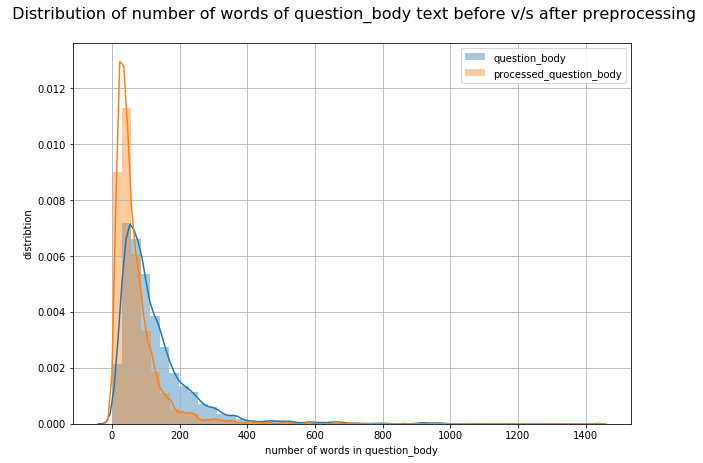

In [308]:
plt.figure(figsize=(10,7))
sns.distplot(question_body_len, label='question_body')
sns.distplot(cleaned_question_body_len, label='processed_question_body')
plt.title(" Distribution of number of words of question_body text before v/s after preprocessing\n",fontsize=16)
plt.ylabel("distribtion")
plt.xlabel("number of words in question_body")
plt.legend()
plt.grid()

* 

### Feature Engineering: Text to Image Feature

In [284]:
# Function to convert text into image feature
def convert_to_image_feat(text):
    
    # Encoding text into bytes
    b = text.encode('utf16')
    
    # Decoding into pixel intensity or image feat
    image_feat_array = np.frombuffer(b,dtype = np.uint8)
    
    return image_feat_array

In [285]:
# Convert to image feature 
question_body_image_features = train_df['question_body'].apply(lambda x: convert_to_image_feat(x))

# Padding using keras pad_sequences
padded_question_body_image_features = tensorflow.keras.preprocessing.sequence.pad_sequences(question_body_image_features, maxlen=10000, dtype='int32', padding='post')


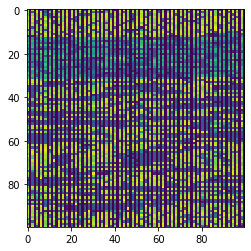

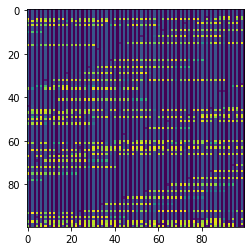

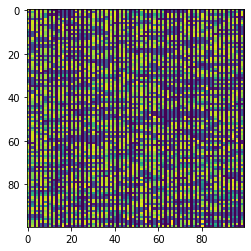

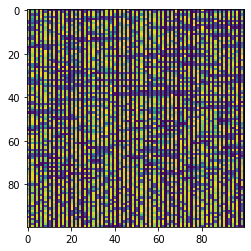

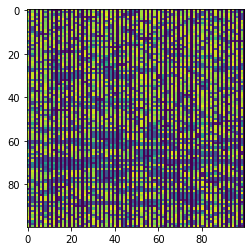

In [289]:
# Sample plot
for i in np.where(np.array(question_body_image_features_len)>10000)[0][5:10]:
    
    # uncomment to see how different question_body has different image structure
    # print(train_df.question_body[i])
    
    plt.imshow(padded_question_body_image_features[i].reshape(100,100))
    plt.show()